In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from particle import Particle

import Utilities.Functions as Functions
import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
from Utilities.ipython_exit import exit

print ('Success')


Success


# Purpose
The purpose of this script is to look at the kinematics of the various samples before and after selections. It should be able to inform decisions made in the full analysis chain. 

The kinematics vary signficantly between different masses of HNL, this script should make plots which give insight into those differences.

# Reading in .pkl files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_lepton_signal":False, #Just e+e- samples, Majorana
          "Load_pi0_signal":True, #Just pi0 samples, Majorana
          "Load_lepton_dirac":False, #Just e+e-, Dirac
          "Load_pi0_dirac":False, #Just pi0, Dirac
          "Load_standard_bkgs":False, #Backgrounds, 'overlay', 'dirtoverlay' and 'beamoff'
          "Load_data":False, #'beamgood' sample
          "Load_DetVars":False, #overlay Detector variations
          "Load_Signal_DetVars":False, #e+e- Detector variation samples
          "Load_pi0_signal_DetVars":False, #pi0 Detector variation samples
          "Only_keep_common_DetVar_evs":True, #For DetVar samples, only keep events common between samples
          "FLATTEN":False, #Have one row per reconstructed object in the dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":True, #Load the "mc_" type variables for signal
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":'beamgood'} 

Params, samples = Functions.new_create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"


Loading these run3 samples: 
['150_pi0', '180_pi0', '200_pi0', '220_pi0', '240_pi0', '245_pi0']


In [3]:
samples_dict = Functions.Load_initial_pkls(samples, Params, loc_pkls, "_full_Finished")

samples_dict.keys()

dict_keys(['150_pi0', '180_pi0', '200_pi0', '220_pi0', '240_pi0', '245_pi0'])

In [4]:
# samples_dict['100_ee'].keys()

In [5]:
def check_variable(df,variable,debug=True): #The df should NOT be flattened. Will return a series which can be plotted. 
    first_entry = df.index[0]
    if isinstance(df[variable][first_entry], (np.ndarray)):
        if(debug):print("This variable has an array of entries per event.")
        Num_events = len(df[variable])
        if(debug):print("The total number of events is " + str(Num_events))
        copy_column = df[variable].copy()
        exploded = copy_column.explode(variable)
        Num_nans = exploded.isna().sum()
        if(debug):print("The number of events with empty arrays is " + str(Num_nans))
        if(debug):print("Fraction of non-empty arrays is " + str(1-(Num_nans/Num_events)))
        Nans_removed = exploded.dropna()
        Num_entries = len(Nans_removed)
        if(debug):print("The total number of entries is " + str(Num_entries))
        
        return Nans_removed, Num_entries
    if isinstance(df[variable][first_entry], (int,float,np.int32,np.float32,np.uint32,np.nan)):
        if(debug):print("This variable has one entry per event.")
        Num_events = len(df[variable])
        if(debug):print("The total number of events is " + str(Num_events))
        copy_column = df[variable].copy()
        Num_nans = copy_column.isna().sum()
        if Num_nans != 0:
            if(debug):print("There are " + str(Num_nans) + " Nan values, removing now")
            copy_column.dropna()
        Num_entries = len(copy_column)
        return copy_column, Num_entries
    else: print("Not sure what type this variable is!")
    
def remove_non_reco_vals(df,debug=True): #Feed in the output of the check_variable
    #value = -1e15
    value = -9999
    first_entry = df.index[0]
    if(debug):print("Total number of entries is " + str(len(df)))
    if(debug):print("Number of very negative values is " + str(len(df.loc[df < value])))

    if(len(df.loc[df < value]) > 0):
        new_df = df.drop(df.loc[df < value].index) #Removes values entirely
        if(debug):print("New number of entries is " + str(len(new_df)))
            # if(len(df.loc[df == -1.0]) > 0):
            #     df.loc[(df == -1.0), variable] = new_value #Sets the new value
            # if(len(df.loc[df == np.nan]) > 0):
            #     df.loc[(df == np.nan), variable] = new_value #Sets the new value
            # if(len(df.loc[df == np.inf]) > 0):
            #     df.loc[(df == np.inf), variable] = new_value #Sets the new value
    else: new_df = df.copy()
    return new_df, len(new_df)

In [6]:
av_HNL_direction = [0.32, 0.74, -0.59] #obtianed from the weighted files, which save the HNL momenta

Run = Params["Run"] #so far either "run1" or "run3"

load_lepton_signal = True
load_pi0_signal = False

FLATTEN = False #Mostly put as False

Truth_vars = True

only_presel = False

load_bkgs = False

signal_like = False #Should set lepton and pi0 loading vars to False

if FLATTEN == True:
    Flat_state = "flattened"
else:
    Flat_state = "unflattened"
    
if only_presel:
    variables_string = "Presel_vars"
elif Truth_vars:
    variables_string = "Truth_vars"
else:
    variables_string = "my_vars"

print(f"Loading {Run} pickles")

loc_pkls = f"pkl_files/{Run}/current_files/{variables_string}/"

end_str="_full_Finished"

if load_bkgs == True:
    overlay_from_pkl = pd.read_pickle(loc_pkls+f"overlay_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
    dirt_from_pkl = pd.read_pickle(loc_pkls+f"dirt_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
    EXT_from_pkl = pd.read_pickle(loc_pkls+f"EXT_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
    print("Overlay .pkl is "+str(len(overlay_from_pkl))+" entries long.")
    print("Dirt .pkl is "+str(len(dirt_from_pkl))+" entries long.")
    print("EXT .pkl is "+str(len(EXT_from_pkl))+" entries long.")

signal_samples_dict = {}

# HNL_masses = [20, 50, 100, 150, 180, 200]
HNL_masses = Constants.HNL_mass_samples

if load_lepton_signal == True:
    for HNL_mass in HNL_masses:
        # signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
        signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
        signal_samples_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV Signal .pkl is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")
    
if load_pi0_signal == True:
    pi0_signal_samples_dict = {}
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        # signal_from_pkl = pd.read_pickle(loc_pkls+f"pi0_signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}_truth.pkl")
        signal_from_pkl = pd.read_pickle(loc_pkls+f"pi0_signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}_truth.pkl")
        # pi0_signal_samples_dict[HNL_mass] = signal_from_pkl
        signal_samples_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV pi0 signal .pkl is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")

elif signal_like == True:
    signal_like_dict = {}
    pkl_variable_tests_loc = f"pkl_files/{Run}/current_files/Variable_tests/"
    for HNL_mass in HNL_masses:
        signal_from_pkl = pd.read_pickle(pkl_variable_tests_loc+f"signal_like_{HNL_mass}_MeV.pkl")
        signal_like_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV Signal .pkl is "+str(len(signal_like_dict[HNL_mass]))+" entries long.")
        
print(f"Successfully loaded {Run} pkls")

Loading run3 pickles
2MeV Signal .pkl is 45159 entries long.
10MeV Signal .pkl is 44463 entries long.
20MeV Signal .pkl is 46022 entries long.
50MeV Signal .pkl is 44579 entries long.
100MeV Signal .pkl is 45304 entries long.
150MeV Signal .pkl is 44975 entries long.
Successfully loaded run3 pkls


In [7]:
# samples_dict["100_ee"].keys()

## Reconstructed Multiplicity study

In [8]:
var = 'n_showers'
plot_dict = {}
Num_entries_dict = {}
debug = False

plot_all_masses = True
if plot_all_masses == True: plot_samples = samples_dict.keys()
if plot_all_masses == False: plot_samples = [10, 100, 150]

for sample in plot_samples:
    print(f"Mass is {sample} MeV")
    plot_dict[sample], Num_entries_dict[sample] = check_variable(samples_dict[sample],var,debug=debug)
    plot_dict[sample], Num_entries_dict[sample] = remove_non_reco_vals(plot_dict[sample],debug=debug)
    
print()
var_2 = 'n_tracks'
plot_dict_2 = {}
Num_entries_dict_2 = {}

for sample in plot_samples:
    print(f"Mass is {sample} MeV")
    plot_dict_2[sample], Num_entries_dict_2[sample] = check_variable(samples_dict[sample],var_2,debug=debug)
    plot_dict_2[sample], Num_entries_dict_2[sample] = remove_non_reco_vals(plot_dict_2[sample],debug=debug)

Mass is 150_pi0 MeV
Mass is 180_pi0 MeV
Mass is 200_pi0 MeV
Mass is 220_pi0 MeV
Mass is 240_pi0 MeV
Mass is 245_pi0 MeV

Mass is 150_pi0 MeV
Mass is 180_pi0 MeV
Mass is 200_pi0 MeV
Mass is 220_pi0 MeV
Mass is 240_pi0 MeV
Mass is 245_pi0 MeV


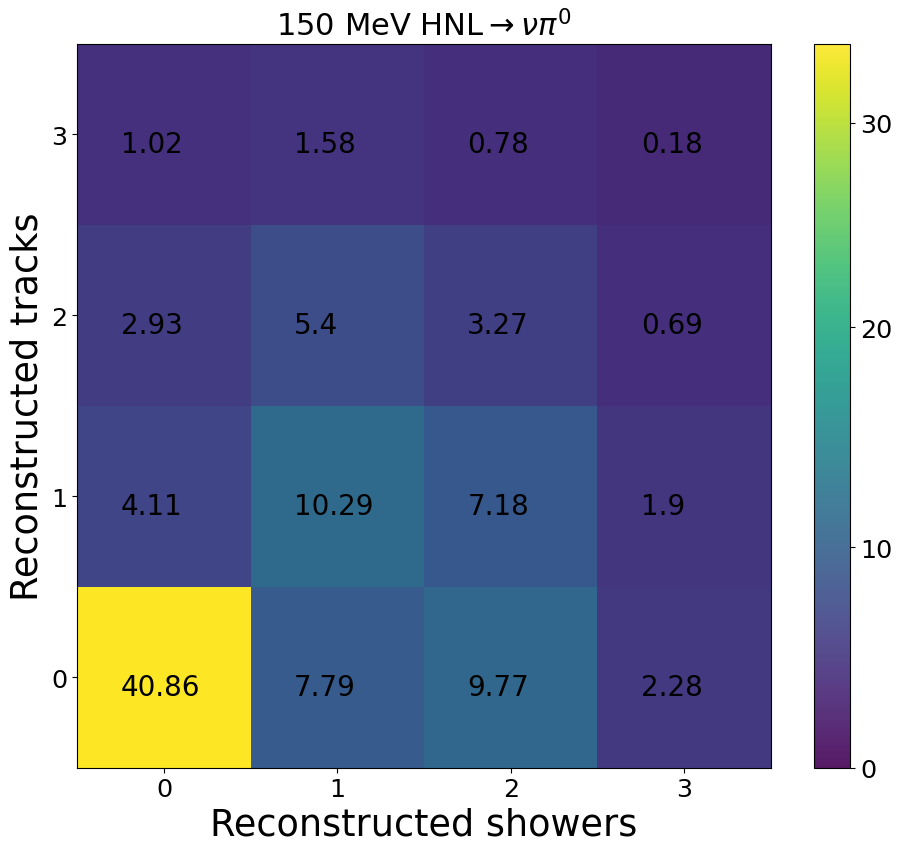

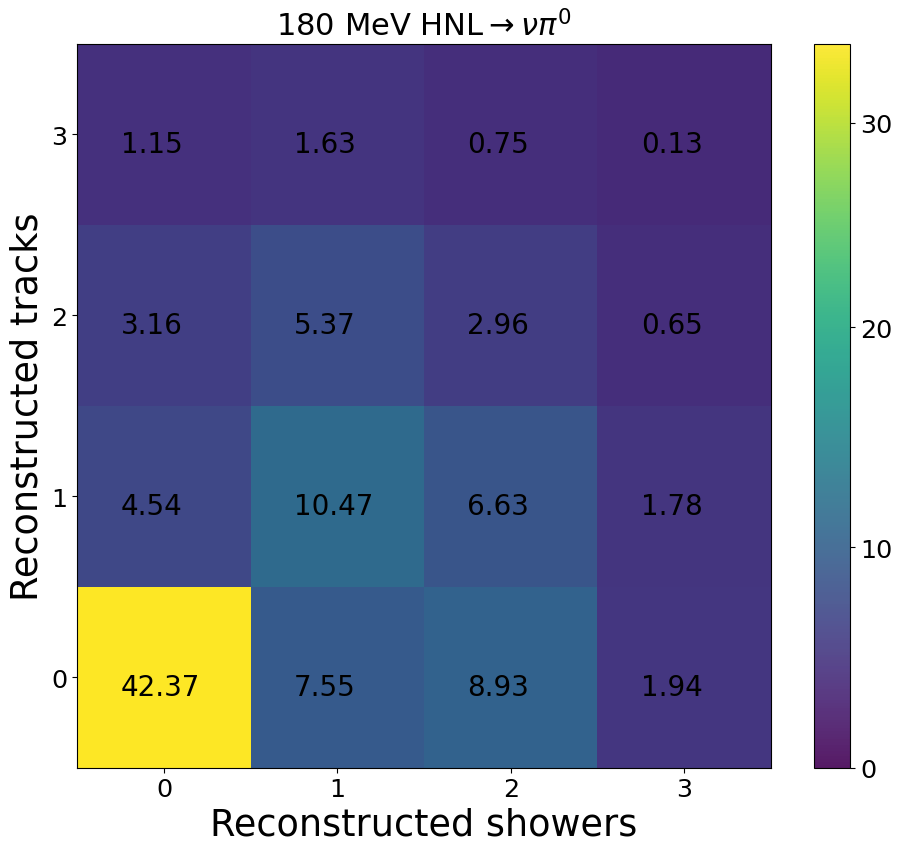

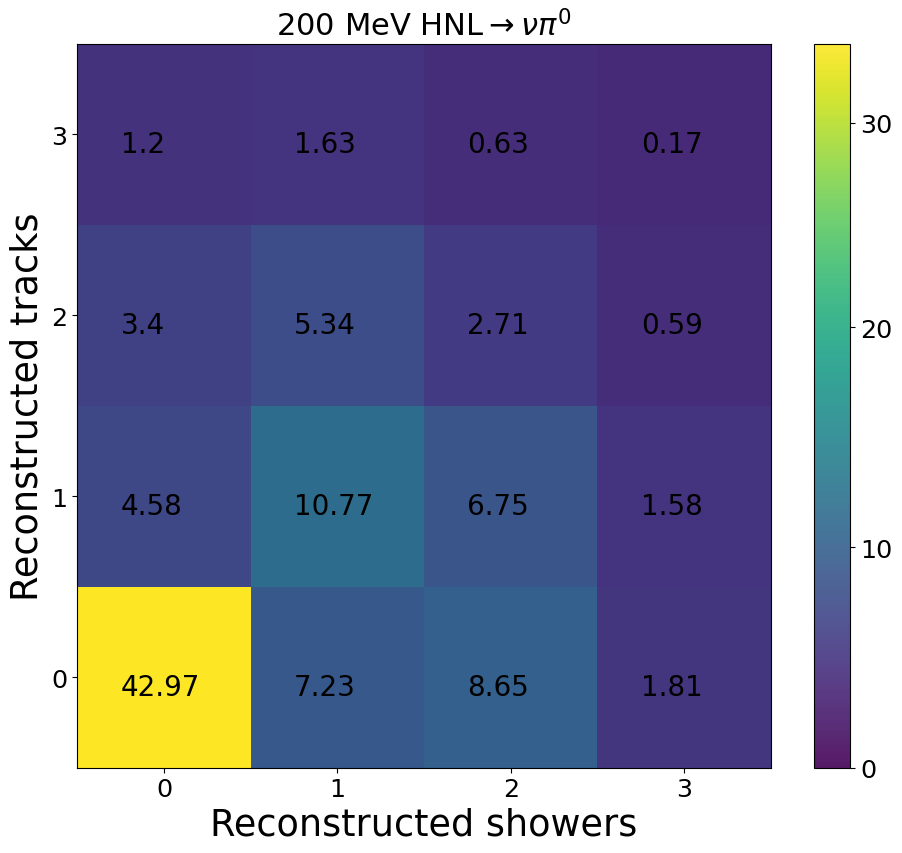

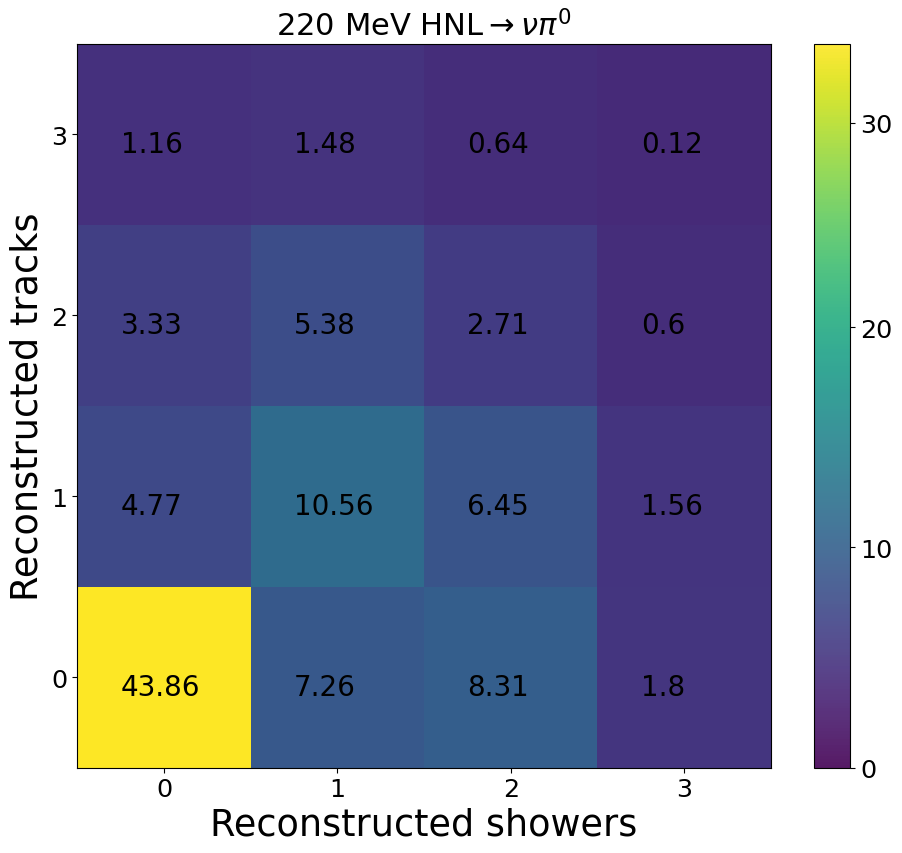

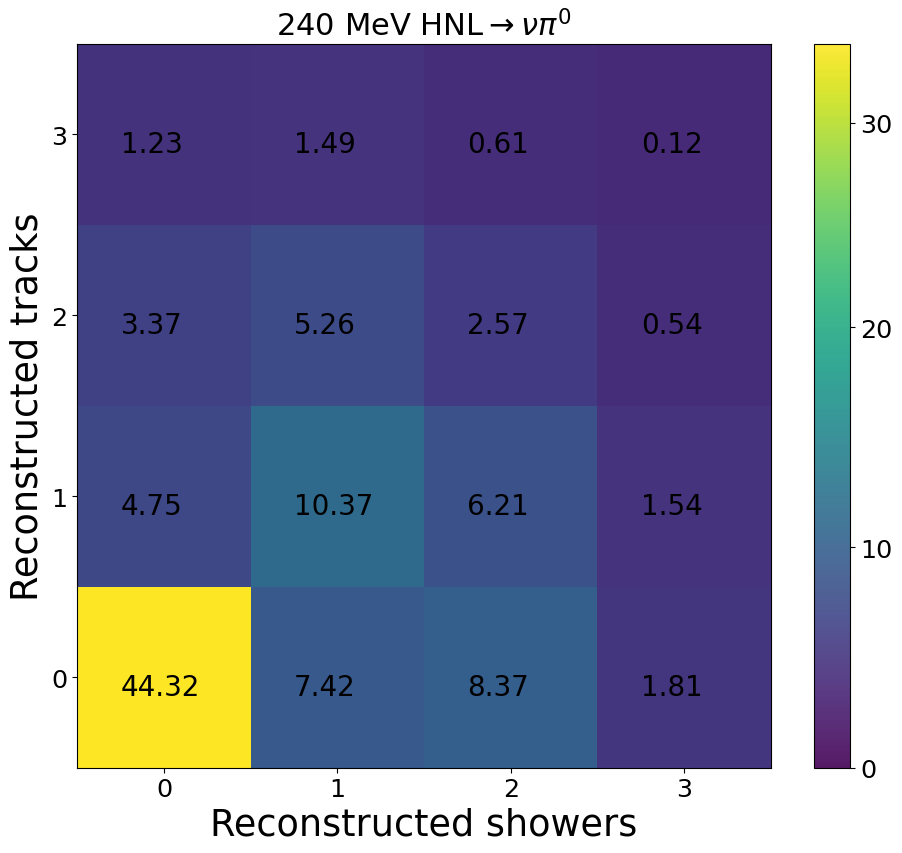

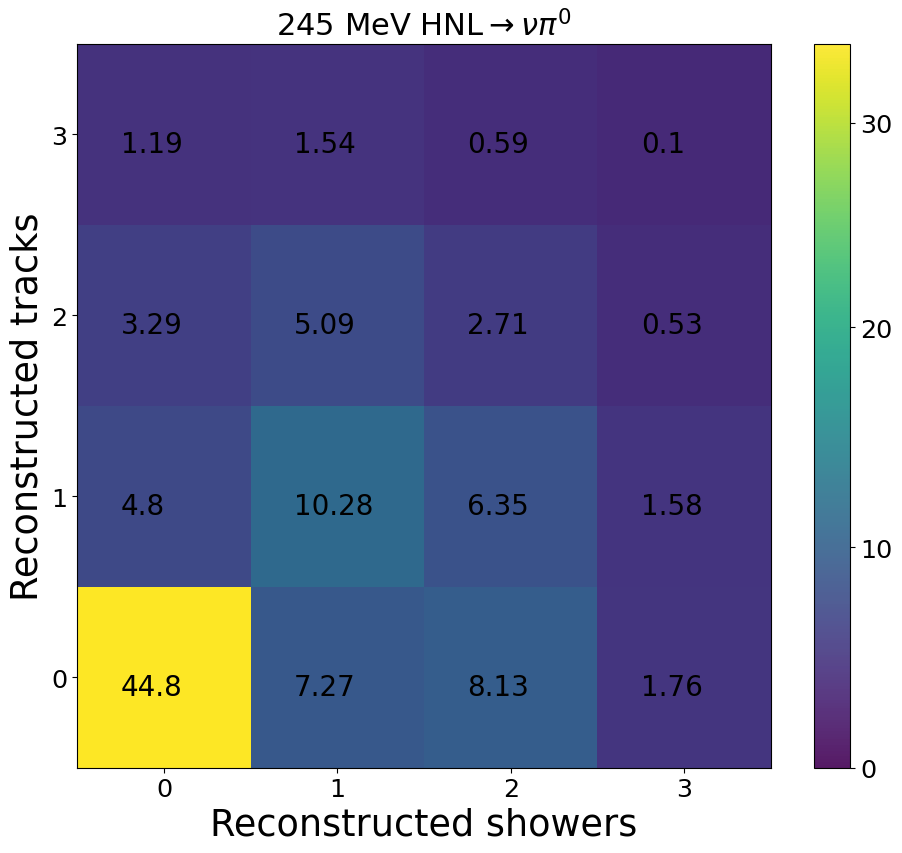

In [9]:
#HNL_mass = 20
savefig=True

for HNL_mass in plot_dict.keys():
    
    mass_str = HNL_mass.split("_")[0]
    dec_type = HNL_mass.split("_")[1]

    n_showers = plot_dict[HNL_mass]
    n_tracks = plot_dict_2[HNL_mass]

    width = 10
    aspect = 0.9
    height = width*aspect
    plt.figure(figsize=(width,height))
    
    BINS = np.arange(5)-0.5
    lims = [-1, 5]
    ticks = [0,1, 2, 3]
    old_bins = 4
    old_lims = [0,4]
    
    low_val = -0.1, #vmin
    high_val = 0.4 #vmax

    plt.hist2d(n_showers, n_tracks, bins = BINS, range=[lims,lims], density=True, cmap="viridis")

    counts, xedges, yedges, Image = plt.hist2d(n_showers, n_tracks, bins = BINS, range=[lims,lims], density=True, cmap="viridis", alpha=0.9)

    dx = xedges[2]-xedges[1]
    dy = yedges[2]-yedges[1]
    for i in range(xedges.size-1):
        for j in range(yedges.size-1):
            xb = xedges[i] + 0.25*dx
            yb = yedges[j] + 0.4*dy
            plt.text(xb, yb, str(np.round(100.*counts[i,j],2)), fontsize=20, color="black") #could change colour to white

    plt.xticks(ticks)
    plt.yticks(ticks)
    if dec_type == "ee":
        plt.title(str(mass_str) + r" MeV HNL$\rightarrow \nu e^{+}e^{-}$")
    if dec_type == "pi0":
        plt.title(str(mass_str) + r" MeV HNL$\rightarrow \nu \pi^{0}$")
    plt.xlabel("Reconstructed showers")
    plt.ylabel("Reconstructed tracks")
    # plt.colorbar(ticks=[0, 0.1, 0.2, 0.3, 0.4])
    cbar = plt.colorbar(ticks=[-0.06, 0.08, 0.22, 0.35, 0.5])
    # plt.colorbar(ticks=[0.0, 0.1, 0.2, 0.3, 0.4])
    plt.clim(-0.06,0.4)
    cbar.ax.set_yticklabels(['0', '10', '20', '30', "40"])
    # plt.colorbar(plt.cm.ScalarMappable(norm=0.5))
    # plt.set_yticklabels(['0.0', '0.2', '0.4', '0.6'])
    
    plt.tight_layout()
    if savefig==True:
        Name = f"Updated_Reconstructed_objects_{HNL_mass}_{Run}"
        if Params["Load_lepton_signal"] == True: 
            plt.savefig("plots/Truth_studies/Signal_plots/ee/" + Name + ".png")
            plt.savefig("plots/Truth_studies/Signal_plots/ee/" + Name + ".pdf")
        if Params["Load_pi0_signal"] == True: 
            plt.savefig("plots/Truth_studies/Signal_plots/pi0/" + Name + ".png")
            plt.savefig("plots/Truth_studies/Signal_plots/pi0/" + Name + ".pdf")

In [ ]:
eleven = Particle.from_pdgid(11)
twelve = Particle.from_pdgid(12)
thirteen = Particle.from_pdgid(13)
fourteen = Particle.from_pdgid(14)
one_one_one = Particle.from_pdgid(111)

print("eleven is " + str(eleven))
print("twelve is " + str(twelve))
print("thirteen is " + str(thirteen))
print("fourteen is " + str(fourteen))
print(one_one_one)

In [ ]:
FLATTEN = True
Flat_state = "flattened"

flat_samples_dict = {}

#Loading files for filtering ee events
if load_lepton_signal == True:
    for HNL_mass in HNL_masses:
        # signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}_New_gen.pkl")
        signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}_truth.pkl")
        flat_samples_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV Signal .pkl is "+str(len(flat_samples_dict[HNL_mass]))+" entries long.")
    
if load_pi0_signal == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        signal_from_pkl = pd.read_pickle(loc_pkls+f"pi0_signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}_truth.pkl")
        flat_samples_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV pi0 signal .pkl is "+str(len(flat_samples_dict[HNL_mass]))+" entries long.")

elif signal_like == True:
    signal_like_dict = {}
    pkl_variable_tests_loc = f"pkl_files/{Run}/current_files/Variable_tests/"
    for HNL_mass in HNL_masses:
        signal_from_pkl = pd.read_pickle(pkl_variable_tests_loc+f"signal_like_{HNL_mass}_MeV.pkl")
        flat_samples_dict[HNL_mass] = signal_from_pkl
        print(f"{HNL_mass}MeV Signal .pkl is "+str(len(signal_like_dict[HNL_mass]))+" entries long.")
        
print(f"Successfully loaded {Run} pkls")

In [ ]:
# signal_samples_dict[150].keys()
flat_samples_dict[150].head()

## Remove e, mu, nu events

In [ ]:
#Make rse_id
for HNL_mass in signal_samples_dict:
    signal_samples_dict[HNL_mass] = Functions.make_unique_ev_id(signal_samples_dict[HNL_mass])
    flat_samples_dict[HNL_mass] = Functions.make_unique_ev_id(flat_samples_dict[HNL_mass])


In [ ]:
#channels: nu,e+,e-, nu,mu,e, nu,mu+,mu- 
#need pdgs of minus 11 and 11. 
e_e_evs = {}
mu_e_evs = {}
mu_plus_e_evs = {}
mu_mu_evs = {}
mu_nu_mu_bar_evs = {}
electrons_dict = {}
positrons_dict = {}

pi0_dict = {}
nu_dict = {}

if load_lepton_signal == True:
    for HNL_mass in signal_samples_dict:
        print(f"Original length is of {HNL_mass}MeV " + str(len(flat_samples_dict[HNL_mass])))
        elec = flat_samples_dict[HNL_mass].query("mc_pdg==11")
        positron = flat_samples_dict[HNL_mass].query("mc_pdg==-11")
        
        mu = flat_samples_dict[HNL_mass].query("mc_pdg==13")
        mu_bar = flat_samples_dict[HNL_mass].query("mc_pdg==-13")
        nu_mu_bar = flat_samples_dict[HNL_mass].query("mc_pdg==-14")

        electrons_dict[HNL_mass] = elec
        positrons_dict[HNL_mass] = positron

        e_e = Functions.make_common_evs_df([elec, positron])
        mu_e = Functions.make_common_evs_df([positron, mu])
        mu_plus_e = Functions.make_common_evs_df([mu_bar, elec])
        mu_mu = Functions.make_common_evs_df([mu, mu_bar])
        mu_nu_mu_bar = Functions.make_common_evs_df([mu_bar, nu_mu_bar])
        # mu_mu = Functions.make_common_evs_df([mu, mu_bar, nu_mu_bar])
        
        e_e_evs[HNL_mass]=e_e
        mu_e_evs[HNL_mass]=mu_e
        mu_plus_e_evs[HNL_mass]=mu_plus_e
        mu_mu_evs[HNL_mass]=mu_mu
        mu_nu_mu_bar_evs[HNL_mass]=mu_nu_mu_bar
        # print("Num ee decays is " + str(len(common_evs[HNL_mass])*2))
common_evs = {}
if load_pi0_signal == True: 
    for HNL_mass in signal_samples_dict:
        print(f"Original length is of FLAT {HNL_mass}MeV " + str(len(flat_samples_dict[HNL_mass])))
        print(f"Original length is of {HNL_mass}MeV " + str(len(signal_samples_dict[HNL_mass])))
        pi0 = flat_samples_dict[HNL_mass].query("mc_pdg==111")
        nu = flat_samples_dict[HNL_mass].query("mc_pdg==-12 or mc_pdg==12")

        pi0_dict[HNL_mass] = pi0
        nu_dict[HNL_mass] = nu

        common = Functions.make_common_evs_df([pi0, nu])
        common_evs[HNL_mass]=common

        print("Num pi0 decays is " + str(len(common_evs[HNL_mass])))

In [ ]:
frac_ee, frac_mumu, frac_emu = {}, {}, {}
frac_all_mus, frac_all_emus = {}, {}
if load_lepton_signal == True:
    for HNL_mass in signal_samples_dict:
        frac_ee[HNL_mass] = len(e_e_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_mumu[HNL_mass] = len(mu_mu_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_emu[HNL_mass] = len(mu_e_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_all_emus[HNL_mass] = (len(mu_e_evs[HNL_mass])+len(mu_plus_e_evs[HNL_mass]))/len(signal_samples_dict[HNL_mass])
        frac_all_mus[HNL_mass] = (len(mu_mu_evs[HNL_mass])+len(mu_nu_mu_bar_evs[HNL_mass]))/len(signal_samples_dict[HNL_mass])
        
        print(f"{HNL_mass} emu frac is " + str(frac_all_emus[HNL_mass]))


In [ ]:
frac_ee.keys()
print(len(frac_ee.keys()))
e_mu_plus_ee, mu_mu_plus_others = {}, {}
for HNL_mass in signal_samples_dict:
    e_mu_plus_ee[HNL_mass] =  frac_ee[HNL_mass]+frac_all_emus[HNL_mass]
    print(e_mu_plus_ee[HNL_mass])
    mu_mu_plus_others[HNL_mass] = e_mu_plus_ee[HNL_mass] + frac_mumu[HNL_mass]
print(frac_ee.values())
print(e_mu_plus_ee.values())

In [ ]:
x_int_list = range(0, len(frac_ee.keys()))
plt.bar(x_int_list, frac_ee.values(), label=r"$\nu e^{+}e^{-}$", tick_label=list(frac_ee.keys()))
plt.bar(x_int_list, frac_all_emus.values(), label=r"$\nu e\mu$", tick_label=list(frac_ee.keys()), bottom=list(frac_ee.values()))
plt.bar(x_int_list, frac_all_mus.values(), label=r"$\nu \mu\mu$", tick_label=list(frac_ee.keys()),bottom=list(e_mu_plus_ee.values()))

plt.axhline(1.0,ls="--", color="black")
plt.ylabel("Fraction of events")
plt.xlabel("HNL mass [MeV]")
plt.xlim(-0.5, 13)
plt.legend(fontsize=22, loc="center right")

plt.savefig("plots/Generator/channel_fractions_current_samples.pdf")

In [ ]:
common_evs.keys()

In [ ]:
signal_samples_dict.keys()

In [ ]:
# common_evs = e_e_evs
filtered_dict, filtered_out_dict = {}, {}
no_emu, no_category_dict = {}, {}
nothing_dict, final_nothing_dict = {}, {}

for HNL_mass in signal_samples_dict:
    filtered_dict[HNL_mass] = signal_samples_dict[HNL_mass].loc[(signal_samples_dict[HNL_mass]['rse_id'].isin(common_evs[HNL_mass]['rse_id']))]
    filtered_out_dict[HNL_mass] = signal_samples_dict[HNL_mass].loc[(~signal_samples_dict[HNL_mass]['rse_id'].isin(common_evs[HNL_mass]['rse_id']))]
    
#     no_emu[HNL_mass] =filtered_out_dict[HNL_mass].loc[(~filtered_out_dict[HNL_mass]['rse_id'].isin(mu_e_evs[HNL_mass]['rse_id']))]
#     no_category_dict[HNL_mass] =no_emu[HNL_mass].loc[(~no_emu[HNL_mass]['rse_id'].isin(mu_mu_evs[HNL_mass]['rse_id']))]
#     nothing_dict[HNL_mass] =no_category_dict[HNL_mass].loc[(~no_category_dict[HNL_mass]['rse_id'].isin(mu_nu_mu_bar_evs[HNL_mass]['rse_id']))]
#     final_nothing_dict[HNL_mass]=nothing_dict[HNL_mass].loc[(~nothing_dict[HNL_mass]['rse_id'].isin(mu_plus_e_evs[HNL_mass]['rse_id']))]
# print(len(final_nothing_dict[245]))


In [ ]:
# eleven is e-
# twelve is nu(e)
# thirteen is mu-
# fourteen is nu(mu)
# print(len(nothing_dict[240]))
# final_nothing_dict[240]["mc_pdg"].head(30)

In [ ]:
filtered_index_dict = {}
for HNL_mass in signal_samples_dict:
    filtered_index_dict[HNL_mass] = filtered_dict[HNL_mass].index


In [ ]:
Num_evs = len(signal_samples_dict[150])
print(Num_evs)
entries = np.arange(0, Num_evs,1)
print(entries)

## Creating new variables

In [ ]:
print(signal_samples_dict[150]['mc_E'][0][0]/signal_samples_dict[150]['mc_E'][0][1])
df = signal_samples_dict[150]
dot_product = (df['mc_px'][0]*df['mc_px'][1] + df['mc_py'][0]*df['mc_py'][1] + df['mc_pz'][0]*df['mc_pz'][1])
print(type(dot_product))
print(dot_product)
print(df['mc_px'][0])
print(max(df['mc_px'][0]))
print(min(df['mc_px'][0]))

print("Num evs is " + str(len(signal_samples_dict[150])))

In [ ]:
def Make_new_variables(df, entries=[]): #For unflattened dfs
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    # Num_evs = len(df)
    mc_p_magnitude = []
    mc_px_sum, mc_py_sum, mc_pz_sum = [], [], []
    mc_E_leading, mc_E_sub, mc_E_asymmetry = [], [], []
    mc_cos_opening_angle, mc_opening_angle = [], []
    
    # for i in range(Num_evs):
    for i in entries_it:
        mc_p1 = np.sqrt(df['mc_px'][i][0]**2+df['mc_py'][i][0]**2+df['mc_pz'][i][0]**2)
        mc_p2 = np.sqrt(df['mc_px'][i][1]**2+df['mc_py'][i][1]**2+df['mc_pz'][i][1]**2)
        mc_p_magnitude.append(np.array([mc_p1,mc_p2]))
        mc_px_sum.append(df['mc_px'][i][0]+df['mc_px'][i][1])
        mc_py_sum.append(df['mc_py'][i][0]+df['mc_py'][i][1])
        mc_pz_sum.append(df['mc_pz'][i][0]+df['mc_pz'][i][1])
        mc_E_leading.append(max(df['mc_E'][i]))
        mc_E_sub.append(min(df['mc_E'][i]))
        mc_E_asymmetry.append(min(df['mc_E'][i]) / max(df['mc_E'][i]))
        
        dot_product = (df['mc_px'][i][0]*df['mc_px'][i][1] + df['mc_py'][i][0]*df['mc_py'][i][1] + df['mc_pz'][i][0]*df['mc_pz'][i][1])
        magnitude_dot_product = mc_p1*mc_p2
        mc_cos_opening_angle.append(dot_product/magnitude_dot_product)
        mc_opening_angle.append(np.arccos(dot_product/magnitude_dot_product))
        
        
    df2 = df.copy()
    df2["mc_px_sum"], df2["mc_py_sum"], df2["mc_pz_sum"] = np.array(mc_px_sum), np.array(mc_py_sum), np.array(mc_pz_sum)
    df2["mc_p_magnitude"] = mc_p_magnitude
    df2["mc_E_leading"], df2["mc_E_sub"] = np.array(mc_E_leading), np.array(mc_E_sub)
    df2["mc_E_asymmetry"] = np.array(mc_E_asymmetry)
    df2["mc_cos_opening_angle"] = np.array(mc_cos_opening_angle)
    df2["mc_opening_angle"] = np.array(mc_opening_angle)
   
    return df2

def Make_angle_wrt(df, vector, entries=[]):
    """
    Vector should be a unit vector, for the desired direction. 
    """
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    # Num_evs = len(df)
    
    polar_angle = []
    # for i in range(Num_evs):
    for i in entries_it:
        direction = vector[0]*df["mc_px_sum"][i] + vector[1]*df["mc_py_sum"][i] + vector[2]*df["mc_pz_sum"][i]
        p_sum = np.sqrt(df["mc_px_sum"][i]+df["mc_py_sum"][i]+df["mc_pz_sum"][i])
        polar_angle.append(np.arccos(direction/p_sum))
        
    df2 = df.copy()
    df2["mc_polar_angle"] = np.array(polar_angle)
    
    return df2

def Make_single_new_variables(df, rest_mass, entries=[]):
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    
    mc_p_magnitude = []
    mc_E_kinetic = []
    for i in entries_it:
        mc_p = np.sqrt(df['mc_px'][i]**2+df['mc_py'][i]**2+df['mc_pz'][i]**2)
        mc_E = df['mc_E'][i] - rest_mass
        
        mc_p_magnitude.append(mc_p)
        mc_E_kinetic.append(mc_E)
        
    df2 = df.copy()
    df2["mc_p_magnitude"] = mc_p_magnitude
    df2["mc_E_kinetic"] = mc_E_kinetic
    
    return df2

def Make_single_angle(df, vector, entries=[]):
    """
    Vector should be a unit vector, for the desired direction. 
    """
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    # Num_evs = len(df)
    
    polar_angle = []
    # for i in range(Num_evs):
    for i in entries_it:
        direction = vector[0]*df["mc_px"][i] + vector[1]*df["mc_py"][i] + vector[2]*df["mc_pz"][i]
        p_sum = np.sqrt(df["mc_px"][i]+df["mc_py"][i]+df["mc_pz"][i])
        polar_angle.append(np.arccos(direction/p_sum))
        
    df2 = df.copy()
    df2["mc_polar_angle_single"] = np.array(polar_angle)
    
    return df2


In [ ]:
for HNL_mass in signal_samples_dict:
    # signal_samples_dict[HNL_mass]=Make_new_variables(signal_samples_dict[HNL_mass], filtered_index_dict[HNL_mass])
    signal_samples_dict[HNL_mass]=Make_new_variables(signal_samples_dict[HNL_mass], signal_samples_dict[HNL_mass].index)
    print(f"Done {HNL_mass}MeV")
print("Done")
    
# direction = [0, 0, 1]
direction = av_HNL_direction

for HNL_mass in signal_samples_dict:
    signal_samples_dict[HNL_mass]=Make_angle_wrt(signal_samples_dict[HNL_mass], direction, [])
    # if load_pi0_signal == True:
    #     pi0_dict[HNL_mass]=Make_single_angle(pi0_dict[HNL_mass], direction, filtered_index_dict[HNL_mass])
    print(f"Done {HNL_mass}MeV")
# test_df = Make_new_variables(signal_samples_dict[2])

In [ ]:
signal_samples_dict[150].keys()

In [ ]:
pi0_dict[150].head()

In [ ]:
pi0_mass = 0.135 #GeV
direction = av_HNL_direction
if load_pi0_signal == True:
    for HNL_mass in pi0_dict:
        pi0_dict[HNL_mass]=Make_single_new_variables(pi0_dict[HNL_mass], pi0_mass, entries=pi0_dict[HNL_mass].index)
        pi0_dict[HNL_mass]=Make_single_angle(pi0_dict[HNL_mass], direction, entries=pi0_dict[HNL_mass].index)
        print(f"Done {HNL_mass}")

# Functions

In [ ]:
def Plot_variable_signal(variable, HNL_samples_dict=[], xlabel=[], xlims=[0,0], bins=40, figsize=[10,10], dpi=100, xticks=[], 
                         density=True,legloc="best",logy = False, cutline = None, savefig=False, filename=None, plot_entries=False,fraction=False):
    
    if(HNL_samples_dict==[]): raise Exception("Specify samples dict") 
    if(xlabel==[]): xlabel=variable
    
    if logy == True:
        logscale="log"
    elif logy == False:
        logscale="linear"
    
    fig,ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=figsize,dpi=dpi)
    
    for HNL_mass in HNL_samples_dict:
    
        #var_HNL=HNL_samples_dict[HNL_mass][variable] #old way when specifying variable
        var_HNL=HNL_samples_dict[HNL_mass]
        Num_entries = len(var_HNL)
       
        if xlims[0] == 0 and xlims[1] == 0: xlims = [min(var_HNL),max(var_HNL)]
    
        if(isinstance(bins, int)):
            nbins=bins
            bins=np.linspace(xlims[0],xlims[1],nbins+1)
        else: nbins=len(bins)-1
    
    #plt.sca(ax[0])
               
        if plot_entries==True: label=[f"{HNL_mass} MeV HNL: " + str(Num_entries) + " entries"]
        if plot_entries==False: label=[f"{HNL_mass} MeV HNL"]
                   
        if fraction == False:
            plt.hist(var_HNL,
    #               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
                  label=label,
                  range=xlims,bins=bins,
                  stacked=False,density=density,
                  histtype="step",lw=3)
        if fraction == True:
            plt.hist(var_HNL,weights=np.ones(len(var_HNL)) / len(var_HNL),
                     label=label,
                  range=xlims,bins=bins,
                  stacked=False,density=False,
                  histtype="step",lw=3)
    
    if(isinstance(cutline, (int,float))):
        plt.axvline(x=cutline, lw=3, color='green', linestyle = 'dashed')
    
    if(logy == True):
        plt.yscale("log")
    else:
        plt.yscale("linear")
        
    if(density == True):
        plt.ylabel("Fraction of total events")
    
    plt.legend(loc=legloc,frameon=False)
    
    plt.xlabel(xlabel)
    plt.xlim(xlims)
    if xticks != []:
        plt.xticks(xticks)
    # plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.tight_layout()
    plt.yscale(logscale)
    if filename == None:
        Name = variable + "_" + Run + "_" + logscale
    else:
        Name = filename
    if savefig == True:
        plt.savefig("plots/Truth_studies/Signal_plots/" + Name + ".png")
        plt.savefig("plots/Truth_studies/Signal_plots/" + Name + ".pdf")

In [ ]:
def check_variable(df,variable,debug=True): #The df should NOT be flattened. Will return a series which can be plotted. 
    first_entry = df.index[0]
    if isinstance(df[variable][first_entry], (np.ndarray)):
        if(debug):print("This variable has an array of entries per event.")
        Num_events = len(df[variable])
        if(debug):print("The total number of events is " + str(Num_events))
        copy_column = df[variable].copy()
        exploded = copy_column.explode(variable)
        Num_nans = exploded.isna().sum()
        if(debug):print("The number of events with empty arrays is " + str(Num_nans))
        if(debug):print("Fraction of non-empty arrays is " + str(1-(Num_nans/Num_events)))
        Nans_removed = exploded.dropna()
        Num_entries = len(Nans_removed)
        if(debug):print("The total number of entries is " + str(Num_entries))
        
        return Nans_removed, Num_entries
    if isinstance(df[variable][first_entry], (int,float,np.int32,np.float32,np.uint32,np.nan)):
        if(debug):print("This variable has one entry per event.")
        Num_events = len(df[variable])
        if(debug):print("The total number of events is " + str(Num_events))
        copy_column = df[variable].copy()
        Num_nans = copy_column.isna().sum()
        if Num_nans != 0:
            if(debug):print("There are " + str(Num_nans) + " Nan values, removing now")
            copy_column.dropna()
        Num_entries = len(copy_column)
        return copy_column, Num_entries
    else: print("Not sure what type this variable is!")
    
def remove_non_reco_vals(df,debug=True): #Feed in the output of the check_variable
    #value = -1e15
    value = -9999
    first_entry = df.index[0]
    if(debug):print("Total number of entries is " + str(len(df)))
    if(debug):print("Number of very negative values is " + str(len(df.loc[df < value])))

    if(len(df.loc[df < value]) > 0):
        new_df = df.drop(df.loc[df < value].index) #Removes values entirely
        if(debug):print("New number of entries is " + str(len(new_df)))
            # if(len(df.loc[df == -1.0]) > 0):
            #     df.loc[(df == -1.0), variable] = new_value #Sets the new value
            # if(len(df.loc[df == np.nan]) > 0):
            #     df.loc[(df == np.nan), variable] = new_value #Sets the new value
            # if(len(df.loc[df == np.inf]) > 0):
            #     df.loc[(df == np.inf), variable] = new_value #Sets the new value
    else: new_df = df.copy()
    return new_df, len(new_df)

In [ ]:
variable_names_dict = {'mc_px_sum':"Sum of x-momenta [GeV]", 'mc_py_sum':"Sum of y-momenta [GeV]", 'mc_pz_sum':"Sum of z-momenta [GeV]",
                       'mc_p_magnitude':"Magnitude of lepton momenta [GeV]", 'mc_E_leading':"Leading lepton energy [GeV]",
                       'mc_E':"Energy [GeV]", 'mc_px':"Momentum in x-direction [GeV]", 'mc_py':"Momentum in y-direction [GeV]",
                       'mc_pz':"Momentum in z-direction [GeV]", 'mc_p_magnitude':"Momentum [GeV]", 'mc_E_kinetic':"Kinetic energy [GeV]",
       'mc_E_sub':"Sub-leading lepton energy [GeV]", 'mc_E_asymmetry':"Energy asymmetry", 'mc_cos_opening_angle':"cosine(opening angle)",
       'mc_opening_angle':"Opening angle [radians]", 'mc_polar_angle':"Angle w.r.t parent HNL [radians]",
                       "mc_polar_angle_single":"Angle w.r.t parent HNL [radians]"}


In [ ]:
Plot_only_lepton = False #Final state is e+e-
Plot_only_pi0 = True #Final state is pi0

if Plot_only_lepton == True: sample_dict = signal_samples_dict
elif Plot_only_pi0 == True: sample_dict = pi0_dict
elif signal_like == True: sample_dict = signal_like_dict

print_vals = input("Do you want to print all the variables in the sample? y/n ")
if print_vals == "y":
    var_list = []
    for var in sample_dict[150].keys():
        var_list.append(var)
    print(var_list)
else:
    print("Not printing variables.")

In [ ]:
var = 'mc_p_magnitude'
plot_dict = {}
Num_entries_dict = {}
debug = False

plot_all_masses = False
if plot_all_masses == True: plot_samples = sample_dict.keys()
if plot_all_masses == False: plot_samples = [150, 180, 200, 240, 245]

for sample in plot_samples:
    print(f"Mass is {sample} MeV")
    plot_dict[sample], Num_entries_dict[sample] = check_variable(sample_dict[sample],var,debug=debug)
    plot_dict[sample], Num_entries_dict[sample] = remove_non_reco_vals(plot_dict[sample],debug=debug)
    
print()
var_2 = 'mc_polar_angle_single'
plot_dict_2 = {}
Num_entries_dict_2 = {}

for sample in plot_samples:
    print(f"Mass is {sample} MeV")
    plot_dict_2[sample], Num_entries_dict_2[sample] = check_variable(sample_dict[sample],var_2,debug=debug)
    plot_dict_2[sample], Num_entries_dict_2[sample] = remove_non_reco_vals(plot_dict_2[sample],debug=debug)
    
# plot_dict[150].head()
# Particle.from_pdgid(11)
print()
var_3 = 'mc_E_kinetic'
plot_dict_3 = {}
Num_entries_dict_3 = {}
if load_pi0_signal == True:
    for sample in pi0_dict:
        print(f"Mass is {sample} MeV")
        plot_dict_3[sample], Num_entries_dict_3[sample] = check_variable(pi0_dict[sample],var_3,debug=debug)
        plot_dict_3[sample], Num_entries_dict_3[sample] = remove_non_reco_vals(plot_dict_3[sample],debug=debug)

In [ ]:
if load_pi0_signal == True:
    Plot_variable_signal(var_3, HNL_samples_dict=plot_dict_3, xlabel=variable_names_dict[var_3], xlims=[0,2.0], bins=50, 
                     figsize=[8,8], dpi=100, xticks=[], density=True,legloc="best",logy = False,
                     cutline = None, savefig=True, filename = f"pi0_{var_3}_{Run}")

In [ ]:
#mc_E Includes rest mass I believe. 
x_ticks = [0,0.05,0.1, 0.15, 0.2]
Plot_variable_signal(var, HNL_samples_dict=plot_dict, xlabel=variable_names_dict[var], xlims=[0,0.2], bins=50, 
                     figsize=[8,8], dpi=100, xticks=x_ticks, density=True,legloc="best",logy = False,
                     cutline = None, savefig=True, filename = f"pi0_{var}_{Run}")
# plt.xticks([0,0.05,0.1, 0.15, 0.2])
# plt.ylim([0,10])
# max_y, bin_edges = np.histogram(plot_dict[150], density=True, bins=40)
# maxium = max(max_y)
# max_x = max(bin_edges)
# min_x = min(bin_edges)
# print(maxium)
# print(max_x)
# print(min_x)
# print("Max minus min is " + str(max_x - min_x))
# plt.ylim(0, maxium*1.3)

In [ ]:
Plot_variable_signal(var_2, HNL_samples_dict=plot_dict_2, xlabel=variable_names_dict[var_2], xlims=[0,3.2], bins=50, 
                     figsize=[8,8], dpi=100, xticks=[], density=True,legloc="upper left",logy = False,
                     cutline = None, savefig=True, filename = f"pi0_{var_2}_{Run}")

In [ ]:
sample_dict[220].keys()

## 2D histogram of reco showers and tracks

In [ ]:
def Make_fraction_recod(HNL_samples_dict=signal_samples_dict, variable='n_pfps'): #This should be fed with a dict of unflattened dataframes
    frac_pfps_dict = {}
    for HNL_mass in HNL_samples_dict:
        Placeholder_list = []
        Num_events = len(HNL_samples_dict[HNL_mass][variable])
        for i in range(max(HNL_samples_dict[HNL_mass][variable])):
            selection = HNL_samples_dict[HNL_mass].loc[(HNL_samples_dict[HNL_mass][variable] == i)]
            Num_multiplicity = len(selection)
            Placeholder_list.append(Num_multiplicity/Num_events)
        frac_pfps_dict[HNL_mass] = Placeholder_list
    return frac_pfps_dict

In [ ]:
frac_pfps_dict = Make_fraction_recod(HNL_samples_dict=sample_dict, variable='n_pfps')

print(frac_pfps_dict)

In [ ]:
HNL_mass = 150
selection = sample_dict[HNL_mass].loc[(sample_dict[HNL_mass]['n_pfps'] == 2)]

print(len(selection))

# End of code